In [1]:
import logging
import os
import random
import math
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
# import torchvision
# import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import wandb
from source.domain.pytorch_wrappers import EarlyStopping

# save weights and biases api key to .env file in project directory
assert os.getenv('WANDB_API_KEY')
assert torch.cuda.is_available()

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)  # noqa: NPY002
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

# Device configuration
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

logging.config.fileConfig(
    os.path.join(os.getcwd(), '/code/source/config/logging.conf'),
    # defaults={'logfilename': os.path.join(os.getcwd(), 'tests/test_files/log.log')},
    disable_existing_loggers=False,
)

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
wandb.login()

2023-12-29 20:03:56 - ERROR    | Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: shane-kercheval. Use `wandb login --relogin` to force relogin


True

In [3]:
x, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')
x = torch.tensor(x.values, dtype=torch.float32)
y = torch.tensor(y.astype(int).values, dtype=torch.long)

# need to make this dynamic based on Fully Connected vs Convolutional
# Reshape data to have channel dimension
# MNIST images are 28x28, so we reshape them to [batch_size, 1, 28, 28]
x = x.reshape(-1, 1, 28, 28)

# 80% train; 10% validation; 10% test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

logging.info(f"Training set  : X-{x_train.shape}, y-{y_train.shape}")
logging.info(f"Validation set: X-{x_val.shape}, y-{y_val.shape}")
logging.info(f"Test set      : X-{x_test.shape}, y-{y_test.shape}")

2023-12-29 20:04:01 - INFO     | Training set  : X-torch.Size([56000, 1, 28, 28]), y-torch.Size([56000])
2023-12-29 20:04:01 - INFO     | Validation set: X-torch.Size([7000, 1, 28, 28]), y-torch.Size([7000])
2023-12-29 20:04:01 - INFO     | Test set      : X-torch.Size([7000, 1, 28, 28]), y-torch.Size([7000])


In [4]:
class ConvNet(nn.Module):
    """Convolutional neural network (two convolutional layers)."""

    def __init__(self, kernels: list, classes: int = 10):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, kernels[0], kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, kernels[1], kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7 * 7 * kernels[-1], classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass."""
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        return self.fc(out)

In [5]:
def make_loader(x: torch.tensor, y: torch.tensor, batch_size: int) -> DataLoader:
    """Make a DataLoader from a given dataset."""
    return DataLoader(
        dataset=TensorDataset(x, y),
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True,
        num_workers=2,
    )


def make(config: dict) -> tuple:
    """Make the model, data, and optimization objects."""
    # Make the data
    train_loader = make_loader(x_train, y_train, batch_size=config.batch_size)
    validation_loader = make_loader(x_val, y_val, batch_size=config.batch_size)
    test_loader = make_loader(x_test, y_test, batch_size=config.batch_size)

    # Make the model
    model = ConvNet(config.kernels, config.classes).to(DEVICE)

    # Make the loss and optimizer
    criterion = nn.CrossEntropyLoss()

    if config.optimizer == 'Adam':
        optimizer_creator = lambda lr: torch.optim.Adam(model.parameters(), lr=lr)  # noqa: E731
    elif config.optimizer == 'SGD':
        optimizer_creator = lambda lr: torch.optim.SGD(model.parameters(), lr=lr)  # noqa: E731
    else:
        raise ValueError(f"Unknown optimizer: {config.optimizer}")

    learning_rates = config.learning_rates
    if isinstance(learning_rates, float):
        learning_rates = [learning_rates]

    return (
        model,
        train_loader,
        validation_loader,
        test_loader,
        criterion,
        optimizer_creator,
        learning_rates,
    )


def train_log(
        training_loss: float,
        validation_loss: float,
        example_ct: int,
        epoch: int,
        learning_rate: float) -> None:
    """Logs loss to the console and wandb."""
    # Where the magic happens
    wandb.log(
        {
            'epoch': epoch,
            'learning_rate': learning_rate,
            'training_loss': training_loss,
            'validation_loss': validation_loss,
        },
        step=example_ct,
    )
    logging.info(
        f"Training/Validation Loss after {str(example_ct).zfill(5)} examples: "
        f"{training_loss:.3f} | {validation_loss:.3f}",
    )


def calculate_average_loss(
        data_loader: DataLoader,
        model: nn.Module,
        loss_func: callable) -> float:
    """Calculates the average loss over a dataset."""
    running_loss = 0
    total_samples = 0
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)  # noqa: PLW2901
            loss = loss_func(model(x), y)
            # weighted average of the loss adjusted for the batch size
            running_loss += loss.item() * x.shape[0]
            total_samples += x.shape[0]
    return running_loss / total_samples


def train(
        model: nn.Module,
        train_loader: DataLoader,
        validation_loader: DataLoader,
        criterion: callable,
        optimizer_creator: callable,
        learning_rates: list[float],
        config: dict) -> None:
    """
    Trains the model for the number of epochs specified in the config. Uses early stopping to
    prevent overfitting. Takes multiple learning rates and if early stopping is triggered, the
    learning rate is reduced and training is continued until no learning rates remain.
    """
    model.train()
    # Tell wandb to watch what the model gets up to: gradients, weights, and more!
    wandb.watch(model, criterion, log="all", log_freq=10)

    # Run training and track with wandb
    example_ct = 0  # number of examples seen

    log_interval = 30 # i.e. every 30 batches
    total_batches = len(train_loader)
    log_interval = max(1, math.floor(total_batches / log_interval))

    early_stopping = EarlyStopping(
        model=model,
        patience=3,
        delta=0.05,  # new loss is required to be >%5 better than previous best
        delta_type='relative',
        verbose=True,
    )
    learning_rate = learning_rates.pop(0)
    optimizer = optimizer_creator(lr=learning_rate)
    for epoch in tqdm(range(config.epochs)):
        logging.info(f"Epoch {epoch} - learning rate: {learning_rate}")
        running_training_loss = 0
        total_train_samples = 0
        for batch_index, (x_batch, y_batch) in enumerate(train_loader):
            x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)  # noqa: PLW2901
            # ➡ Forward pass
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            # ⬅ Backward pass & optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            example_ct += len(x_batch)
            # weighted average of the training loss
            running_training_loss += loss.item() * x_batch.shape[0]
            total_train_samples += x_batch.shape[0]
            # Report metrics every 25th batch
            if batch_index % log_interval == 0:
                avg_training_loss = running_training_loss / total_train_samples
                running_training_loss = 0
                total_train_samples = 0
                model.eval()
                average_validation_loss = calculate_average_loss(
                    data_loader=validation_loader, model=model, loss_func=criterion,
                )
                train_log(
                    avg_training_loss,
                    average_validation_loss,
                    example_ct,
                    epoch,
                    learning_rate,
                )
                model.train()

        if early_stopping(average_validation_loss):
            logging.info("Early stopping. Loading previous best state.")
            # we have stopped training (for this learning rate), load the previous best state
            model.load_state_dict(early_stopping.best_state)
            # if we have more learning rates, reset the optimizer and early stopping and
            # continue training
            if learning_rates:
                learning_rate = learning_rates.pop(0)
                logging.info(f"Reducing learning rate: {learning_rate}")
                optimizer = optimizer_creator(lr=learning_rate)
                early_stopping.reset()
            else:
                break

    wandb.log({
        'best_validation_loss': early_stopping.lowest_loss,
        'best_epoch': early_stopping.best_index,
    })
    logging.info(f"Best validation loss: {early_stopping.lowest_loss:.3f}")
    logging.info(f"Best early stopping index/epoch: {early_stopping.best_index}")


def plot_misclassified_sample(
        num_images: int,
        images: torch.tensor,
        predictions: np.array,
        labels: np.array) -> None:
    """Plot a sample of the misclassified images."""
    fig, ax = plt.subplots(nrows=num_images // 5, ncols=5, sharex=True, sharey=True)
    ax = ax.flatten()
    mismatched_indexes = np.where(predictions != labels)[0]
    rows = np.random.choice(mismatched_indexes, size=num_images, replace=False)  # noqa: NPY002
    for i, row in enumerate(rows):
        # img = X_test[row].cpu().numpy().reshape(28, 28)
        img = images[row].cpu().numpy().reshape(28, 28)
        ax[i].imshow(img, cmap='Greys')
        title_color = 'red' if predictions[row] != y_test[row] else 'black'
        ax[i].set_title(f'P:{predictions[row]} - A:{y_test[row]}', color=title_color)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    wandb.log({'sample-misclassified': wandb.Image(fig)})


def plot_heatmap(predictions: np.array, labels: np.array) -> None:
    """Plot a heatmap of the misclassified samples."""
    # create a heatmap of misclassified samples
    cm = confusion_matrix(labels, predictions)
    # remove the diagonal values (correct predictions) for better visualization
    np.fill_diagonal(cm, 0)
    fig = plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Count of Misclassified Samples by Class')
    wandb.log({'count-misclassified': wandb.Image(fig)})


def plot_scores(precision: list, recall: list, f1: list) -> None:
    """Plot the precision, recall, and f1 scores for each class."""
    # create a bar plot
    x = range(10)
    width = 0.2
    fig, ax = plt.subplots()
    _ = ax.bar(x, precision, width, label='Precision')
    _= ax.bar([i + width for i in x], recall, width, label='Recall')
    _ = ax.bar([i + 2 * width for i in x], f1, width, label='F1')
    # add labels, title, and legend
    ax.set_xlabel('Class')
    ax.set_ylabel('Score')
    ax.set_title('Accuracy Metrics by Class')
    ax.set_xticks([i + width for i in x])
    ax.set_xticklabels(range(10))
    ax.legend()
    # find the minimum and maximum score values (from precision, recall, and f1 lists) and set the
    # y limits slightly wider to make the plot easier to read
    ymin = min(*precision, *recall, *f1)
    ymax = max(*precision, *recall, *f1)
    ax.set_ylim([ymin - 0.03, min(ymax + 0.03, 1)])
    wandb.log({'scores': wandb.Image(fig)})


def test(model: nn.Module, test_loader: DataLoader, criterion: callable) -> None:
    """Tests the model on the test set. Logs the accuracy to the console and to wandb."""
    model.eval()
    avg_test_loss = calculate_average_loss(data_loader=test_loader, model=model, loss_func=criterion)  # noqa
    logging.info(f"Average Loss on test set: {avg_test_loss:.3f}")
    wandb.log({'test_loss': avg_test_loss})

    # Log confusion matrix
    with torch.no_grad():
        all_predictions = []
        all_labels = []
        for x, y in test_loader:
            x, y = x.to(DEVICE), y.cpu().numpy()  # noqa: PLW2901
            outputs = model(x)
            predictions = torch.argmax(outputs.data, dim=1).cpu().numpy()
            all_predictions.extend(predictions)
            all_labels.extend(y)

    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    plot_misclassified_sample(num_images=30, images=x_test, predictions=all_predictions, labels=all_labels)  # noqa
    plot_heatmap(predictions=all_predictions, labels=all_labels)

    # for each class, calculate the accuracy metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_true=all_labels, y_pred=all_predictions)  # noqa
    score_table = wandb.Table(columns=["class", "precision", "recall", "f1"])
    for i in range(10):
        score_table.add_data(str(i), precision[i], recall[i], f1[i])
    wandb.log({"score_table": score_table})
    plot_scores(precision, recall, f1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true=all_labels,
        y_pred=all_predictions,
        average='weighted',
    )
    logging.info(f"Weighted Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
    wandb.log({'weighted_precision': precision, 'weighted_recall': recall, 'weighted_f1': f1})

    # Save the model in the exchangeable ONNX format
    x, _ = next(iter(test_loader))
    torch.onnx.export(model, x.to(DEVICE) , 'model.onnx')
    wandb.save('model.onnx')


def model_pipeline(config: dict) -> nn.Module:
    """Builds the model and runs it."""
    # tell wandb to get started
    project = config.pop('project'); assert project
    tags = config.pop('tags', None)
    notes = config.pop('notes', None)
    with wandb.init(project=project, config=config, tags=tags, notes=notes):
        config = wandb.config
        # make the model, data, and optimization problem
        model, train_loader, validation_loader, test_loader, criterion, optimizer_creator, \
            learning_rates = make(config)
        print(model)
        # and use them to train the model
        train(
            model, train_loader, validation_loader, criterion, optimizer_creator,
            learning_rates, config,
        )
        # and test its final performance
        test(model, test_loader, criterion)

    return model

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


  0%|          | 0/20 [00:00<?, ?it/s]2023-12-29 20:04:03 - INFO     | Epoch 0 - learning rate: 0.005
2023-12-29 20:04:03 - INFO     | Training/Validation Loss after 00064 examples: 18.387 | 54.481
2023-12-29 20:04:04 - INFO     | Training/Validation Loss after 01920 examples: 6.081 | 0.940
2023-12-29 20:04:04 - INFO     | Training/Validation Loss after 03776 examples: 0.773 | 0.601
2023-12-29 20:04:04 - INFO     | Training/Validation Loss after 05632 examples: 0.437 | 0.406
2023-12-29 20:04:05 - INFO     | Training/Validation Loss after 07488 examples: 0.354 | 0.332
2023-12-29 20:04:05 - INFO     | Training/Validation Loss after 09344 examples: 0.298 | 0.273
2023-12-29 20:04:06 - INFO     | Training/Validation Loss after 11200 examples: 0.316 | 0.289
2023-12-29 20:04:06 - INFO     | Training/Validation Loss after 13056 examples: 0.304 | 0.300
2023-12-29 20:04:06 - INFO     | Training/Validation Loss after 14912 examples: 0.290 | 0.267
2023-12-29 20:04:07 - INFO     | Training/Validati

best_index,▁
best_validation_loss,▁
epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,███████████████▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
test_loss,▁
training_loss,█▅▃▃▄▃▃▃▃▃▃▃▄▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█▅▃▂▃▂▂▃▃▂▃▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂
weighted_f1,▁
weighted_precision,▁
weighted_recall,▁
best_index,6


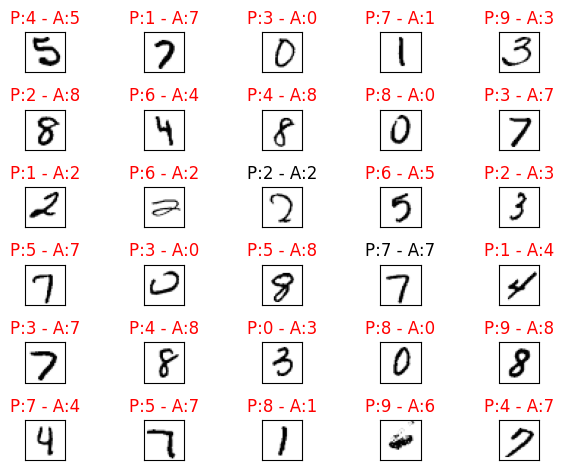

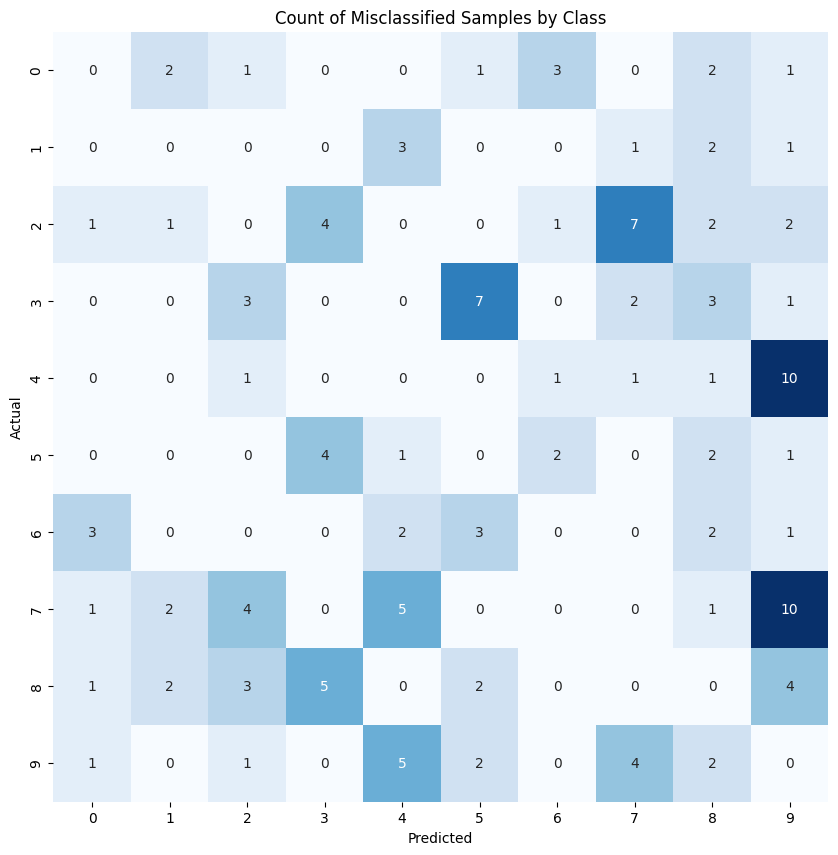

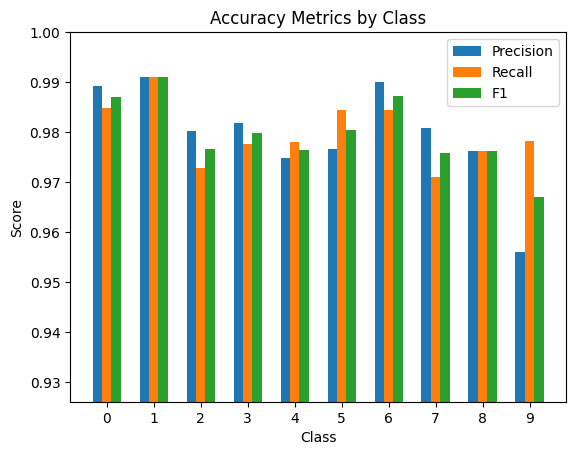

In [6]:
config = {
    'project': 'pytorch-demo',
    'tags': ['pytorch', 'demo'],
    'notes': 'First run with a simple CNN',
    'epochs': 20,
    'classes': 10,
    'kernels': [16, 32],
    'batch_size': 64,
    'optimizer': 'Adam',
    # 'learning_rates': 0.005,
    'learning_rates': [0.005, 0.001, 0.0005],
    'dataset': 'MNIST',
    'architecture': 'CNN',
}
# Build, train and analyze the model with the pipeline
model = model_pipeline(config)